In [1]:
# 1. build the matrix 

# 2. use or tools to optmize 

# 3. flip operations

# . Local search for path only (flips that optmize the path)

# 4. cnn with bayes to evaluate the layout + bandit exploration 

# 5. Algorithms configuration to speedup the CVRP optimizer 

In [6]:
# !pip install --upgrade --user ortools

In [297]:
"""Simple travelling salesman problem between cities."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import math
import random 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline


In [358]:
locations = [(i, j) for i in range(5) for j in range(9) if (i, j) not in [(2, 1), (2,5), (2, 7)]]
locations = [(-1, 4)] + locations
orientation = {loc: 1 if random.random() < 0.5 else 0 for loc in locations}

In [383]:
x_pad=2.5
y_pad=4.0
#TODO add margin
pin_pad_r=0.4
pin_pad_l=2.8
scale=1000
free_l=4

def distance_loc(loc1, loc2, pin1, pin2):
    x1, y1 = loc1
    x2, y2 = loc2
    x1 = x1 * x_pad + x_pad / 2
    x2 = x2 * x_pad + x_pad / 2
    y1 = y1 * y_pad + (pin_pad_l if pin1 else pin_pad_r)
    y2 = y2 * y_pad + (pin_pad_l if pin2 else pin_pad_r)
    dist = math.hypot(x1 - x2, y1 - y2)
    return round(max(dist - free_l, 0) * scale)

In [384]:
def create_data_model(locations, orientation, x_pad=2.5, y_pad=4.0, pin_pad_r=0.2, pin_pad_l=3.7, scale=1000, free_l=4, ):
    """Stores the data for the problem."""
    #pin 1: l, 0: r
    #x: rows, y: cols

    distance = []
    for loc1 in locations:
        distance += [[distance_loc(loc1, loc2, orientation[loc1], orientation[loc2]) for loc2 in locations]]
    
    data = {}
    data['locations'] = locations
    data['orientation'] = orientation
    data['distance_matrix'] = distance
    data['demands'] = [0] + [1 for _ in locations[1:]]
    data['vehicle_capacities'] = [7, 7, 7, 7, 7, 7]
    data['num_vehicles'] = 6
    data['depot'] = 0
    data['initial_routes'] = [
        [10, 19, 25, 34, 36, 27, 20],
       [ 2, 11, 26, 35, 37, 28, 21],
       [ 9, 18, 24, 33, 42, 41, 32],
       [ 8, 17, 16, 23, 31, 30, 22],
       [ 1,  3, 12, 13,  4,  5, 14],
       [ 6,  7, 15, 40, 39, 38, 29]]
    return data

def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    total_distance = 0
    total_load = 0
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        route = []
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route += [node_index]
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        routes += [route + [0]]
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        #print(plan_output)
        total_distance += route_distance
        total_load += route_load
    #print('Total distance of all routes: {}m'.format(total_distance))
    #print('Total load of all routes: {}'.format(total_load))
    return total_distance, routes


In [385]:
def wire(data_model, try_hard=False, time_limit=10):
    """Solve the CVRP problem."""

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    if try_hard:
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        search_parameters.time_limit.seconds = time_limit
        search_parameters.log_search = True
    else:
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.time_limit.seconds = 5
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
#     initial_solution = routing.ReadAssignmentFromRoutes(data['initial_routes'],True)
#     assignment = routing.SolveFromAssignmentWithParameters(initial_solution, search_parameters)
    assignment = routing.SolveWithParameters(search_parameters)

    
    # Print solution on console.
    if assignment:
        total_distance, routes = print_solution(data, manager, routing, assignment)
        return total_distance, routes
    else:
        return None

In [386]:
data = create_data_model(locations, orientation)
best_distance, _ = wire(data)

In [388]:
orientation_best = orientation

In [389]:

for i in range(5000):
    orientation = orientation_best.copy()
    for k, v in orientation.items():
        if random.random() < random.random() / 3.0:
            orientation[k] = 1 - orientation[k] 
        else:
            orientation[k] = orientation[k]

    data = create_data_model(locations, orientation)
    new_distance, _ = wire(data, try_hard=False)
    if new_distance < best_distance:
        
        orientation_best = orientation
        best_distance = new_distance
        print ("\n😮new dist: " + str(new_distance), end = " -> ")
        
        orientation = orientation_best.copy()
        data = create_data_model(locations, orientation)
        new_distance, _ = wire(data, try_hard=True, time_limit=10)
        new_distance

        if new_distance < best_distance:
            orientation_best = orientation
            best_distance = new_distance
            print (str(new_distance) + "*")
    else:
            print ("😔", end = '')
    

😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔
new dist 😮: 53475
new dist*: 51879
😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔
new dist 😮: 51655
😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔😔

In [418]:
def draw_solution(rounts):
    fig, ax = plt.subplots(1)

    # Dummy data
    x = []
    y = []
    for x_, y_ in locations:
        x += [x_ * x_pad]
        y += [y_ * y_pad]
    n = len(x)
    # Dummy errors (above and below)
    xerr = [2 for i in x]
    yerr = [3.7 for i in y]


    facecolor='r'
    edgecolor='None'
    alpha=0.5
    xdata, ydata, xerror, yerror = x, y, xerr, yerr
    errorboxes = []
    pin_boxes = []
    # Loop over data points; create box from errors at each point
    i = 0
    for x_, y_, xe, ye in zip(xdata, ydata, xerror, yerror):
        rect = Rectangle((y_, x_), ye, xe)
        errorboxes.append(rect) 

        rect = Rectangle((y_ + (pin_pad_r if orientation[locations[i]] else pin_pad_l)  - 0.3/2, x_ + 1.25 - 0.3/2), 0.3, 0.3)
        pin_boxes.append(rect) 

        plt.text(y_ + 1.5, x_ + 0.5, str(i), fontsize=12)
        i = i + 1

    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    pc2 = PatchCollection(pin_boxes, facecolor='b', alpha=1,
                         edgecolor='b')

    # Create patch collection with specified colour/alpha
    colors = ['r', 'b', 'g', 'y', 'k', 'm']
    lines = []
    for i in range(len(rounts)):
        line = []
        for j in range(len(rounts[i]) - 1):
            loc_x1, loc_y1 = locations[rounts[i][j]]
            x1 = loc_x1 * x_pad + x_pad / 2
            y1 = loc_y1 * y_pad + (pin_pad_r if orientation[locations[rounts[i][j]]] else pin_pad_l) #+ random.random() / 5 #jitter

            loc_x2, loc_y2 = locations[rounts[i][j + 1]]
            x2 = loc_x2 * x_pad + x_pad / 2
            y2 = loc_y2 * y_pad + (pin_pad_r if orientation[locations[rounts[i][j + 1]]] else pin_pad_l) #+ random.random() / 5
            line += [((x1, y1), (x2, y2))]
        lines += [line]     

    for i in range(len(lines)):
        for ((x1, y1), (x2, y2)) in lines[i]:
            plt.plot((y1, y2), (x1, x2), colors[i])

    # Add collection to axes
    ax.add_collection(pc)
    ax.add_collection(pc2)


    plt.xlim(-1, 36)
    plt.ylim(-5, 15)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [431]:
def eval_solution(sln):
    d = []
    for i in sln:
        for j in range(len(i) - 1):
            d += [distance_loc(
                locations[i[j]], locations[i[j + 1]], orientation[locations[i[j]]], orientation[locations[i[j + 1]]])]
        d += [distance_loc(locations[i[0]], locations[0], orientation[locations[i[0]]], orientation[locations[0]])]
        d += [distance_loc(locations[i[-1]], locations[0], orientation[locations[i[-1]]], orientation[locations[0]])]
    return(sum(d))

50938


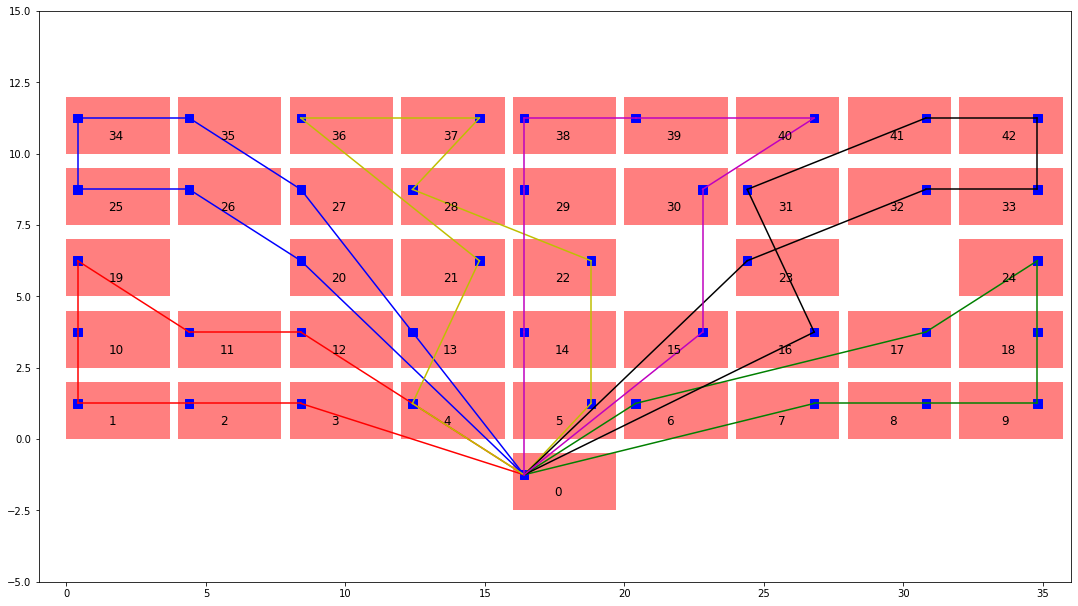

In [432]:
orientation = orientation_best.copy()
data = create_data_model(locations, orientation)
new_distance, rounts = wire(data, try_hard=False, time_limit=10)
new_distance
print(eval_solution(rounts))
draw_solution(rounts)

102177


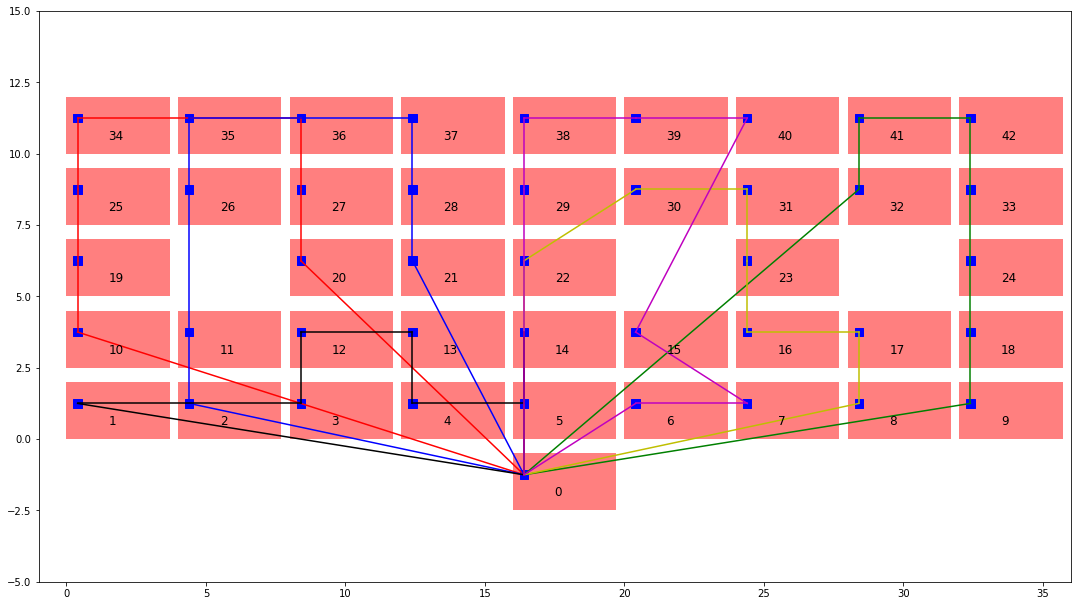

In [433]:
sln = data['initial_routes'] 
print (eval_solution(sln))

orientation = {loc: 1  for loc in locations}
sln_ = [[0] + i + [0] for i in sln]
draw_solution(sln_)
